In [33]:
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.core.problem import ElementwiseProblem
from pymoo.factory import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

warnings.filterwarnings('ignore')

# Import data 

In [34]:
df = pd.read_csv('../data/row/inputs.csv').drop(columns=['freq', 'valor_negociacao'])
df

,porte,media_cenario,frequencia,valor_pessimista,media,valor_otimo,valor_otimista
0,0,863.286180,351,984.0,1100.0,1168.5,1230.0
1,1,1736.081757,171,1920.0,2110.0,2232.5,2350.0
2,2,2264.830895,670,2380.0,2490.0,2490.0,2600.0
3,3,2675.373872,1743,2680.0,2750.0,2750.0,2830.0
4,4,4328.934812,1556,4280.0,4360.0,4360.0,4440.0
5,6,5267.513943,1296,5410.0,5530.0,5530.0,5650.0
6,7,9666.323543,273,9250.0,9840.0,9880.0,10400.0


# Definindo o Problema

In [35]:
class ModelingProblem(ElementwiseProblem):
    def __init__(self, target_lower, target_upper, xl_input, xu_input):
        self.target_lower = target_lower
        self.target_upper = target_upper
        self.xl_input = xl_input
        self.xu_input = xu_input
        self.alpha = 1
    
        super().__init__(
            n_var = 7, 
            n_obj = 2,
            n_constr = 2, 
            xl = xl_input, 
            xu = xu_input
        )
    
    def _evaluate(self, x, out, *args, **kwargs):
        f1 = sum((df.media_cenario - x) * df.frequencia)
        # f2 = - np.std(x * df.frequencia) # v01 inversa do desvio padrão da receita
        f2 = np.std(1/df.frequencia * x * self.alpha)
        
        # x_norm = (x - df.media)/(df.valor_otimista - df.media)
        # f2 =  np.std(x_norm * df.frequencia) # v03
        
        # f2 = sum(np.power(df.frequencia.values, 2) + x_norm) # v04 equação de demanda

        g1 = self.target_lower - sum(x * df.frequencia)
        g2 = sum(x * df.frequencia) - self.target_upper
                                             
        out['F'] = [f1, f2]
        out['G'] = [g1, g2]

# Executar otimização

In [36]:
problem = ModelingProblem(
    24000000,
    24500000,
    df.valor_pessimista,
    df.valor_otimista
) 

nsga2 = NSGA2(
    pop_size = 100,
    n_offsprings = 70,
    eliminate_duplicates=True
)

res_nsga2 = minimize(
    problem,
    nsga2,
    get_termination("n_gen", 200),
    seed=1,
    save_history=True,
    verbose=False,
)

res_x = res_nsga2.X   
res_f = res_nsga2.F
res_hist = res_nsga2.history

# salvar as soluções

In [37]:
def save_solutions(dataframe, solution, save = False, output = None):
    size = len(solution)
    for i in range(size):
        dataframe[f'solution_{i}'] = solution[i]
        
    if save == True:        
        dataframe.to_csv('data/solutions/'+output, index=False)
        
    return dataframe

In [38]:
df_solutions = save_solutions(df.drop(columns=['media_cenario']), res_x)

# Filtrar os resultados

- Buscar Soluções onde os porte 7 mais diminuiu

In [39]:
def smaller_sizes(df_solutions, portes=[7], total_solutions=30):
    df_solutions = df_solutions.drop(
        columns=[
            'frequencia', 
            'valor_pessimista', 
            'media',
            'valor_otimo',
            'valor_otimista',
        ]
    )
    
    aux = df_solutions[df_solutions.porte.isin(portes)]
    df = pd.DataFrame()
    df['solutions'] = aux.columns[1:]
    
    if aux.shape[0] == 0:
        df[f'porte_{portes[0]}'] = aux.values[0][1:]
        df[f'porte_{portes[1]}'] = aux.values[1][1:]
    
    if aux.shape[0] == 1:
        df[f'porte_{portes[0]}'] = aux.values[0][1:]
                
    return df.nsmallest(total_solutions, columns=df.columns[1:], keep='first')

In [40]:
filtro_portes = smaller_sizes(df_solutions)
filtro_portes

,solutions,porte_7
25,solution_25,9250.001386
0,solution_0,9250.006193
46,solution_46,9250.006193
85,solution_85,9250.009420
57,solution_57,9250.057082
91,solution_91,9250.057082
13,solution_13,9250.256448
33,solution_33,9250.301490
6,solution_6,9250.393665
92,solution_92,9250.955095


- Pegar as soluções com maior receita

In [41]:
def receive_solutions(df_solutions, solutions_selected, frequencia=df.frequencia, total_solutions=15):    
    receita = [sum(df_solutions[solutions_selected][s] * frequencia) for s in solutions_selected]
    
    df = pd.DataFrame(columns=['solutions', 'receita'])
    df['solutions'] = solutions_selected
    df['receita'] = receita  
    
    return df.sort_values(by=['receita'], ascending=False).head(total_solutions)

In [42]:
maiores_receitas = receive_solutions(df_solutions, filtro_portes.solutions)
maiores_receitas

,solutions,receita
17,solution_17,2.430147e+07
9,solution_9,2.429741e+07
35,solution_35,2.429421e+07
60,solution_60,2.429213e+07
14,solution_14,2.428663e+07
74,solution_74,2.428503e+07
66,solution_66,2.428373e+07
29,solution_29,2.427785e+07
59,solution_59,2.427500e+07
37,solution_37,2.427369e+07


- Com as maiores receitas, verifique as cinco menores diferenças positivas das soluções em relação aos valores otimos

In [43]:
def dif_receita(max_receive, great_value=df.valor_otimo, freq=df.frequencia, n=5):
    max_receive['dif_receitas'] = max_receive.receita - sum(great_value * freq)
    return max_receive.nsmallest(n, columns='dif_receitas', keep='first')

In [44]:
filtro_dif_receita = dif_receita(maiores_receitas)
filtro_dif_receita

,solutions,receita,dif_receitas
13,solution_13,2.425283e+07,351102.300185
46,solution_46,2.425710e+07,355372.675845
91,solution_91,2.425961e+07,357883.299739
67,solution_67,2.426419e+07,362457.793148
24,solution_24,2.426855e+07,366823.502695


In [45]:
cols = np.append(filtro_dif_receita.solutions, 'porte')
df_solutions[cols]

,solution_13,solution_46,solution_91,solution_67,solution_24,porte
0,1229.996753,1229.999217,1229.999438,1229.983145,1229.999730,0
1,2281.023760,2306.391322,2331.333127,2344.121004,2327.010492,1
2,2599.999801,2599.999806,2599.999668,2599.999772,2599.982358,2
3,2829.999824,2829.999798,2829.998770,2829.999730,2829.998880,3
4,4439.999961,4439.999912,4439.994997,4439.998730,4439.999424,4
5,5649.999897,5649.999972,5648.642824,5649.999674,5649.999829,6
6,9250.256448,9250.006193,9250.057082,9252.355452,9279.086793,7


- Diferença dos portes menos os valores otimistas dos portes 

In [46]:
def dif_portes(df_solutions, max_receive, great_value=df.valor_otimo):
    
    solutions = max_receive['solutions'].values
    cols = np.append(solutions, "porte")
    aux = df_solutions[cols]
    
    df = pd.DataFrame()
    df['portes'] = aux.porte
    
    for i in solutions:
        df[i] = aux[i] - great_value
    
    df = df[df.columns[1:]].T
    df = df.reset_index()

    df.columns = [
        'solutions','dif_porte_0', 
        'dif_porte_1', 'dif_porte_2', 
        'dif_porte_3', 'dif_porte_4', 
        'dif_porte_6','dif_porte_7'
    ]
    
    df['total'] = df.sum(axis = 1)
    return df

In [47]:
df_dif_portes = dif_portes(df_solutions, maiores_receitas)
df_dif_portes

,solutions,dif_porte_0,dif_porte_1,dif_porte_2,dif_porte_3,dif_porte_4,dif_porte_6,dif_porte_7,total
0,solution_17,61.499856,108.188893,109.999218,79.999784,79.999992,119.999575,-488.969631,70.717687
1,solution_9,61.470550,114.294200,109.998166,79.996745,79.997637,119.999576,-507.596352,58.160522
2,solution_35,61.471607,111.709439,109.999856,79.999912,79.997328,119.999992,-517.711452,45.466682
3,solution_60,61.497589,117.281794,109.999765,79.999802,79.999901,119.999984,-528.855660,39.923174
4,solution_14,61.498894,94.546582,109.982115,79.999795,79.999424,119.999981,-534.739098,11.287694
5,solution_74,61.499303,117.038120,109.999989,79.999912,79.999955,119.999598,-554.730836,13.806041
6,solution_66,61.499784,115.751924,109.999807,79.999996,79.998863,119.999973,-558.670192,8.580155
7,solution_29,61.499389,108.703784,109.998569,79.999945,79.998651,119.997837,-575.771280,-15.573105
8,solution_59,61.499997,115.941056,109.999867,79.999878,79.999866,119.999949,-590.772306,-23.331695
9,solution_37,61.499771,113.169684,109.999867,79.998874,79.999424,119.999826,-593.835034,-29.167589


In [48]:
filtro_dif_portes = df_dif_portes.nsmallest(5, columns='total', keep='first')
filtro_dif_portes

,solutions,dif_porte_0,dif_porte_1,dif_porte_2,dif_porte_3,dif_porte_4,dif_porte_6,dif_porte_7,total
14,solution_13,61.496753,48.523760,109.999801,79.999824,79.999961,119.999897,-629.743552,-129.723556
13,solution_46,61.499217,73.891322,109.999806,79.999798,79.999912,119.999972,-629.993807,-104.603781
12,solution_91,61.499438,98.833127,109.999668,79.998770,79.994997,118.642824,-629.942918,-80.974094
11,solution_67,61.483145,111.621004,109.999772,79.999730,79.998730,119.999674,-627.644548,-64.542492
10,solution_24,61.499730,94.510492,109.982358,79.998880,79.999424,119.999829,-600.913207,-54.922495


In [49]:
cols = np.append(filtro_dif_portes.solutions, 'porte')
df_solutions[cols]

,solution_13,solution_46,solution_91,solution_67,solution_24,porte
0,1229.996753,1229.999217,1229.999438,1229.983145,1229.999730,0
1,2281.023760,2306.391322,2331.333127,2344.121004,2327.010492,1
2,2599.999801,2599.999806,2599.999668,2599.999772,2599.982358,2
3,2829.999824,2829.999798,2829.998770,2829.999730,2829.998880,3
4,4439.999961,4439.999912,4439.994997,4439.998730,4439.999424,4
5,5649.999897,5649.999972,5648.642824,5649.999674,5649.999829,6
6,9250.256448,9250.006193,9250.057082,9252.355452,9279.086793,7


- Inversa das Diferença dos portes menos os valores otimistas dos portes 

In [50]:
def inv_dif_portes(df_solutions, max_receive):
    df_dif_portes = dif_portes(df_solutions, max_receive)
    
    df_dif_portes = df_dif_portes.drop(columns=['total'])
    
    cols_dif_portes = df_dif_portes.columns[1:]
    df = df_dif_portes[cols_dif_portes] * -1
    
    df['solutions'] = df_dif_portes.solutions
    df.columns = 'inv_' + df.columns
    df['total'] = df.sum(axis = 1)
    
    return df.sort_values(by=['total'], ascending=True).head(5)

In [51]:
filtro_dif_portes

,solutions,dif_porte_0,dif_porte_1,dif_porte_2,dif_porte_3,dif_porte_4,dif_porte_6,dif_porte_7,total
14,solution_13,61.496753,48.523760,109.999801,79.999824,79.999961,119.999897,-629.743552,-129.723556
13,solution_46,61.499217,73.891322,109.999806,79.999798,79.999912,119.999972,-629.993807,-104.603781
12,solution_91,61.499438,98.833127,109.999668,79.998770,79.994997,118.642824,-629.942918,-80.974094
11,solution_67,61.483145,111.621004,109.999772,79.999730,79.998730,119.999674,-627.644548,-64.542492
10,solution_24,61.499730,94.510492,109.982358,79.998880,79.999424,119.999829,-600.913207,-54.922495


In [52]:
filtro_inv_dif_portes = inv_dif_portes(df_solutions, maiores_receitas)
filtro_inv_dif_portes

,inv_dif_porte_0,inv_dif_porte_1,inv_dif_porte_2,inv_dif_porte_3,inv_dif_porte_4,inv_dif_porte_6,inv_dif_porte_7,inv_solutions,total
0,-61.499856,-108.188893,-109.999218,-79.999784,-79.999992,-119.999575,488.969631,solution_17,-70.717687
1,-61.470550,-114.294200,-109.998166,-79.996745,-79.997637,-119.999576,507.596352,solution_9,-58.160522
2,-61.471607,-111.709439,-109.999856,-79.999912,-79.997328,-119.999992,517.711452,solution_35,-45.466682
3,-61.497589,-117.281794,-109.999765,-79.999802,-79.999901,-119.999984,528.855660,solution_60,-39.923174
5,-61.499303,-117.038120,-109.999989,-79.999912,-79.999955,-119.999598,554.730836,solution_74,-13.806041


In [53]:
cols = np.append(filtro_inv_dif_portes.inv_solutions, 'porte')
df_solutions[cols]

,solution_17,solution_9,solution_35,solution_60,solution_74,porte
0,1229.999856,1229.970550,1229.971607,1229.997589,1229.999303,0
1,2340.688893,2346.794200,2344.209439,2349.781794,2349.538120,1
2,2599.999218,2599.998166,2599.999856,2599.999765,2599.999989,2
3,2829.999784,2829.996745,2829.999912,2829.999802,2829.999912,3
4,4439.999992,4439.997637,4439.997328,4439.999901,4439.999955,4
5,5649.999575,5649.999576,5649.999992,5649.999984,5649.999598,6
6,9391.030369,9372.403648,9362.288548,9351.144340,9325.269164,7


- Modulo das Diferença dos portes menos os valores otimistas dos portes 

In [54]:
def mod_dif_portes(df_solutions, max_receive, total_solutions=5):
    
    df_dif_portes = dif_portes(df_solutions, max_receive)
    
    
    cols_dif_portes = df_dif_portes.columns[1:]
    
    df = abs(df_dif_portes[cols_dif_portes])
    
    df['solutions'] = df_dif_portes.solutions
    df.columns = 'mod_' + df.columns
    df['total'] = df.sum(axis = 1)
    
    return df.sort_values(by=['total'], ascending=True).head(total_solutions)
    

In [55]:
filtro_mod_dif_portes = mod_dif_portes(df_solutions, maiores_receitas)
filtro_mod_dif_portes

,mod_dif_porte_0,mod_dif_porte_1,mod_dif_porte_2,mod_dif_porte_3,mod_dif_porte_4,mod_dif_porte_6,mod_dif_porte_7,mod_total,mod_solutions,total
4,61.498894,94.546582,109.982115,79.999795,79.999424,119.999981,534.739098,11.287694,solution_14,1092.053583
0,61.499856,108.188893,109.999218,79.999784,79.999992,119.999575,488.969631,70.717687,solution_17,1119.374636
2,61.471607,111.709439,109.999856,79.999912,79.997328,119.999992,517.711452,45.466682,solution_35,1126.356267
1,61.470550,114.294200,109.998166,79.996745,79.997637,119.999576,507.596352,58.160522,solution_9,1131.513748
6,61.499784,115.751924,109.999807,79.999996,79.998863,119.999973,558.670192,8.580155,solution_66,1134.500693


In [56]:
cols = np.append(filtro_mod_dif_portes.mod_solutions, 'porte')
df_solutions[cols]

,solution_14,solution_17,solution_35,solution_9,solution_66,porte
0,1229.998894,1229.999856,1229.971607,1229.970550,1229.999784,0
1,2327.046582,2340.688893,2344.209439,2346.794200,2348.251924,1
2,2599.982115,2599.999218,2599.999856,2599.998166,2599.999807,2
3,2829.999795,2829.999784,2829.999912,2829.996745,2829.999996,3
4,4439.999424,4439.999992,4439.997328,4439.997637,4439.998863,4
5,5649.999981,5649.999575,5649.999992,5649.999576,5649.999973,6
6,9345.260902,9391.030369,9362.288548,9372.403648,9321.329808,7


# Frente de Pareto

In [57]:
def frente_pareto(f, media_cenario, media, frequencia, valor_otimo):
    # ordenar f1 e f2 das soluções
    f1_ordenado_decres = sorted(f[:,0], reverse=True) 
    f2_ordenado_cres = sorted(f[:,1])

    # Calculando f1 e f2 para o valor otimo
    f1_valor_otimo = sum((media_cenario - valor_otimo) * frequencia)
    f2_valor_otimo = np.std(1/frequencia * valor_otimo * 1)

    # Calculando f1 e f2 para o valor media
    f1_valor_media = sum((media_cenario -  media) * frequencia)
    f2_valor_media = np.std(1/frequencia * media * 1)

    fig, ax = plt.subplots(figsize=[10, 8], dpi=100)
    ax.scatter(f1_ordenado_decres, f2_ordenado_cres, color="firebrick", label="Soluções NSGA-II")
    ax.scatter(f1_valor_otimo, f2_valor_otimo, color="blue", label="Valor otimo")
    ax.scatter(f1_valor_media, f2_valor_media, color="green", label="Valor media")

    ax.set_ylabel("$f_2$")
    ax.set_xlabel("$f_1$")
    ax.legend()
    fig.tight_layout()


In [58]:
res_f

array([[-1.20912627e+06,  1.06493452e+01],
       [-1.51805804e+06,  1.18196960e+01],
       [-1.36574996e+06,  1.11360008e+01],
       [-1.37512824e+06,  1.11774073e+01],
       [-1.24747073e+06,  1.07105230e+01],
       [-1.32961809e+06,  1.09766412e+01],
       [-1.25906267e+06,  1.07226736e+01],
       [-1.49753898e+06,  1.17208028e+01],
       [-1.33494859e+06,  1.10043467e+01],
       [-1.31548278e+06,  1.09145146e+01],
       [-1.51185450e+06,  1.17851014e+01],
       [-1.43869800e+06,  1.14652924e+01],
       [-1.45962614e+06,  1.15579953e+01],
       [-1.27090955e+06,  1.07446778e+01],
       [-1.30470379e+06,  1.08749554e+01],
       [-1.37907684e+06,  1.11945971e+01],
       [-1.38426393e+06,  1.12174778e+01],
       [-1.31954382e+06,  1.09348634e+01],
       [-1.21993755e+06,  1.06644358e+01],
       [-1.26305283e+06,  1.07401522e+01],
       [-1.42976382e+06,  1.14195009e+01],
       [-1.42377659e+06,  1.13940481e+01],
       [-1.46360253e+06,  1.15714045e+01],
       [-1.

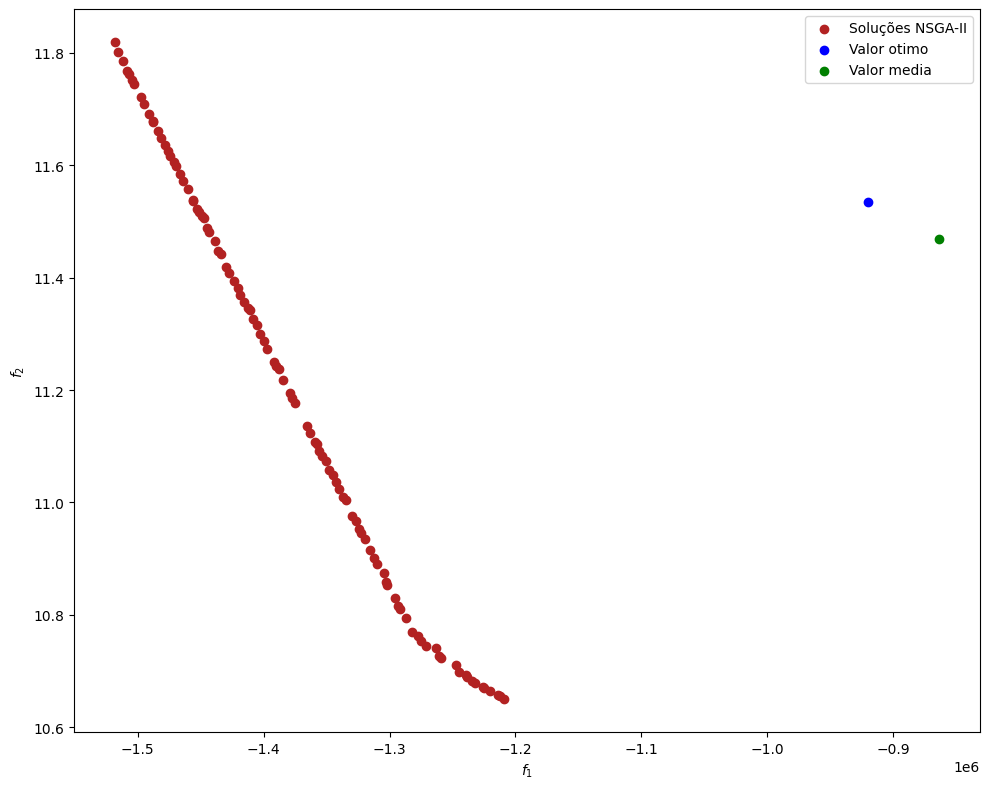

In [59]:
frente_pareto(res_f, df.media_cenario, df.media, df.frequencia, df.valor_otimo)